In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
df = pd.read_csv('car_fuel_efficiency.txt')
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [9]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [10]:
df = df.fillna(0)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [18]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [19]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse = True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)


## Q1 - training a decision tree
* *Which feature is used for splitting the data?* **vehicle_weight**

In [22]:
from sklearn.tree import DecisionTreeRegressor, export_text

dr = DecisionTreeRegressor(max_depth = 1)
dr.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [39]:
from sklearn.tree import export_text
print(export_text(dr, feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



## Q2 - Train a Random Forest Regressor
* *What is the RMSE of the model on the validation data?* **0.45 is the RMSE**

In [40]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 10, random_state = 1, n_jobs = -1)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [44]:
from sklearn.metrics import root_mean_squared_error as rmse
y_pred = rf.predict(X_val)
rmse(y_pred, y_val)

0.4595777223092726

## Q3 Experimenting with *n_estimators*
* *When does RMSE stop improving?* **Improvement is negligible, but answer looks to be closest to 200**

In [45]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators = n, random_state = 1, n_jobs = -1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    scores.append((n, rmse(y_pred, y_val)))


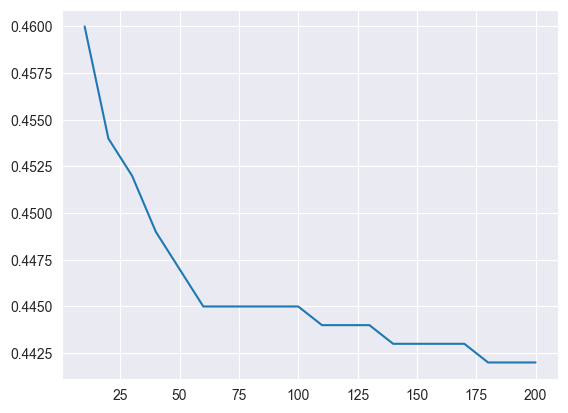

In [81]:
x, y = map(list, zip(*scores))
y = [round(y,3) for y in y]
plt.plot(x, y)

## Q4 Examining *max_depth*
* *What is the best depth, based on mean RMSE?* **Looks like depth=10 is the best**

In [82]:
scores = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(max_depth=d, n_estimators = n, random_state = 1, n_jobs = -1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        scores.append((d, n, rmse(y_pred, y_val)))


In [84]:
score_df = pd.DataFrame(scores, columns = ['depth', 'estimators', 'rmse'])
score_means_df = score_df.groupby('depth')
score_means = score_means_df['rmse'].mean()
print(score_means)

depth
10    0.441808
15    0.445417
20    0.446253
25    0.445910
Name: rmse, dtype: float64


## Q5 Feature importance information
* *Which is the most important feature?* **vehicle_weight *by far***

In [85]:
rf = RandomForestRegressor(max_depth=20, n_estimators = 10, random_state = 1, n_jobs = -1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [91]:
feat_imp = rf.feature_importances_.round(3)

In [92]:
feat_imp

array([0.011, 0.   , 0.   , 0.003, 0.   , 0.   , 0.016, 0.003, 0.002,
       0.002, 0.   , 0.001, 0.001, 0.959])

In [93]:
for n,f in zip(dv.get_feature_names_out(), feat_imp):
    print(n, f)

acceleration 0.011
drivetrain=All-wheel drive 0.0
drivetrain=Front-wheel drive 0.0
engine_displacement 0.003
fuel_type=Diesel 0.0
fuel_type=Gasoline 0.0
horsepower 0.016
model_year 0.003
num_cylinders 0.002
num_doors 0.002
origin=Asia 0.0
origin=Europe 0.001
origin=USA 0.001
vehicle_weight 0.959


## Q6 XGBoost!
* *Which setting for ETA has the best score?* **ETA = 0.1 is the better of the two**

In [94]:
import xgboost as xgb

In [117]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)
watchlist = [(dtrain, 'train'), (dval, 'eval')]

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [118]:
watch = {}
model = xgb.train(xgb_params,dtrain, evals = watchlist, verbose_eval = 5, evals_result = watch, num_boost_round = 100)
y_pred = model.predict(dval)
rmse(y_val, y_pred)

[0]	train-rmse:2.28944	eval-rmse:2.34561
[5]	train-rmse:1.41247	eval-rmse:1.44988
[10]	train-rmse:0.91008	eval-rmse:0.94062
[15]	train-rmse:0.63402	eval-rmse:0.66672
[20]	train-rmse:0.48983	eval-rmse:0.53064
[25]	train-rmse:0.41881	eval-rmse:0.46891
[30]	train-rmse:0.38342	eval-rmse:0.44289
[35]	train-rmse:0.36435	eval-rmse:0.43250
[40]	train-rmse:0.35343	eval-rmse:0.42746
[45]	train-rmse:0.34621	eval-rmse:0.42595
[50]	train-rmse:0.33998	eval-rmse:0.42498
[55]	train-rmse:0.33480	eval-rmse:0.42449
[60]	train-rmse:0.33054	eval-rmse:0.42456
[65]	train-rmse:0.32602	eval-rmse:0.42493
[70]	train-rmse:0.32202	eval-rmse:0.42503
[75]	train-rmse:0.31895	eval-rmse:0.42526
[80]	train-rmse:0.31667	eval-rmse:0.42563
[85]	train-rmse:0.31440	eval-rmse:0.42574
[90]	train-rmse:0.31059	eval-rmse:0.42586
[95]	train-rmse:0.30625	eval-rmse:0.42611
[99]	train-rmse:0.30419	eval-rmse:0.42623


0.42622800553359225

In [113]:
key = 'eta=%s' % (xgb_params['eta'])

def parse_xgb_output(output):
    cols = ['train_rmse','eval_rmse']
    df_results = pd.DataFrame(np.array([output['train']['rmse'],output['eval']['rmse']])).transpose()
    df_results.columns = cols
    return df_results

scores[key] = parse_xgb_output(watch)
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1'])

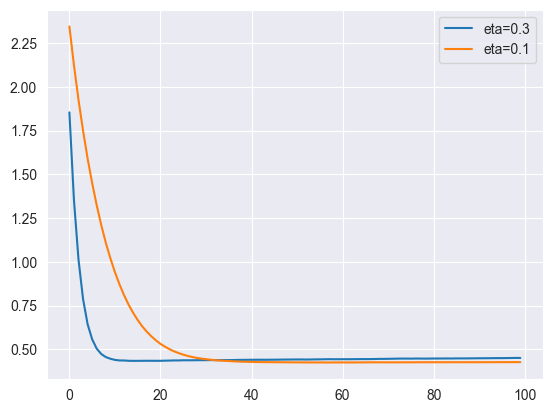

In [114]:
for key, df_scores in scores.items():
    plt.plot(df_scores.eval_rmse, label = key)
plt.legend()